In [49]:
import numpy as np
import pandas as pd
from lightkurve import KeplerTargetPixelFile
import csv
from tqdm import tqdm
from sklearn.cross_validation import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import itertools

In [23]:
# I will create my own dataset that is more indicative of the data at hand.

In [3]:
# columns I want:
# 1. Kepler ID = index
# 2. Minimum(flux)
# 3. Maximum(flux)
# 4. Delta
# 5. first percentile of flux
# 6. 3rd percentile of flux
# 7. 5th percentile of flux
# 8. Target label

In [4]:
xtrain = np.load('xtrainfile2.npy')
xtest = np.load('xtestfile2.npy')

In [5]:
ytrain = np.load('ytrainfile3.npy')
ytest = np.load('ytestfile3.npy')

In [6]:
print(xtest.shape)
print(xtrain.shape)
print(ytrain.shape)
print(ytest.shape)

(2160, 1626)
(5725, 1626)
(5727,)
(2161,)


In [7]:
# find the minimum value for each vector
# put it in a list

minimum = []
for i in range(len(xtrain)):
    minimum.append(np.amin(xtrain[i]))
for i in range(len(xtest)):
    minimum.append(np.amin(xtest[i]))

In [8]:
# find the maximum value for each vector
# put it in a list

maximum = []
for i in range(len(xtrain)):
    maximum.append(np.amax(xtrain[i]))
for i in range(len(xtest)):
    maximum.append(np.amax(xtest[i]))

In [9]:
# find the first percentile
# put it all in a list

first = []
for i in range(len(xtrain)):
    first.append(np.percentile(xtrain[i], 1))
for i in range(len(xtest)):
    first.append(np.percentile(xtest[i], 1))

In [10]:
# find the third percentile
# put it all in a list

third = []
for i in range(len(xtrain)):
    third.append(np.percentile(xtrain[i], 3))
for i in range(len(xtest)):
    third.append(np.percentile(xtest[i], 3))

In [11]:
# find the 5th percentile
# put it all in a list

fifth = []
for i in range(len(xtrain)):
    fifth.append(np.percentile(xtrain[i], 5))
for i in range(len(xtest)):
    fifth.append(np.percentile(xtest[i], 5))

In [12]:
# create delta between min and max
delta = []
for i in range(len(xtrain)):
    delta.append(maximum[i]-minimum[i])
for i in range(len(xtest)):
    delta.append(maximum[i]-minimum[i])

In [13]:
ytest

array([0. , 0. , 0.5, ..., 0.5, 0. , 0. ])

In [14]:
# create target values
target = []
for i in range(len(xtrain)):
    target.append(ytrain[i])
for i in range(len(xtest)):
    target.append(ytest[i])

In [30]:
df = pd.DataFrame({'minimum': minimum,
                   'maximum': maximum,
                   'delta': delta,
                   'firstpercent': first,
                   'thirdpercent': third,
                   'fifthpercent': fifth,
                   'target': target})

In [31]:
df.head()

,delta,fifthpercent,firstpercent,maximum,minimum,target,thirdpercent
0,0.004157,0.999170,0.998773,1.002296,0.998139,0.5,0.999048
1,0.004157,0.999170,0.998773,1.002296,0.998139,0.5,0.999048
2,0.021173,0.995924,0.994854,1.006699,0.985526,0.0,0.995604
3,0.020493,0.998810,0.992693,1.012022,0.991529,0.0,0.996204
4,0.003358,0.999801,0.999660,1.002780,0.999422,0.0,0.999757


# Create Training and Test Sets

In [32]:
df['target'] = (df["target"] == 0.5)

In [33]:
df.head()

,delta,fifthpercent,firstpercent,maximum,minimum,target,thirdpercent
0,0.004157,0.999170,0.998773,1.002296,0.998139,True,0.999048
1,0.004157,0.999170,0.998773,1.002296,0.998139,True,0.999048
2,0.021173,0.995924,0.994854,1.006699,0.985526,False,0.995604
3,0.020493,0.998810,0.992693,1.012022,0.991529,False,0.996204
4,0.003358,0.999801,0.999660,1.002780,0.999422,False,0.999757


In [34]:
x = df.drop(['target'], axis=1)
y = df['target']

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=40, stratify=y)

# Fixing Class Imbalance

In [38]:
train_majority = (y_train==False)
train_majority.value_counts()

True     3005
False    2908
Name: target, dtype: int64

In [ ]:
# its actually fine

# Function to Plot Confusion Matrices

In [47]:
# define a function to draw beautiful confusion matrix!

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Reds):

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

# Modeling
### Random Forest

In [67]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
parameters = {'max_depth': list(range(1,20)), 'n_estimators': list(range(1,100))}


In [39]:
# Fit a Random Forest Model to the dataset

randomforest = RandomForestClassifier(class_weight = 'balanced', max_depth=20, n_estimators=100, random_state=76)
randomforest.fit(x_train, y_train)

#y_pred_proba = randomforest.predict_proba(x_test)[:,1]
#threshold = 0.4
#y_cutoff = np.where(y_pred_proba >= threshold, 1, 0)
y_pred = randomforest.predict(x_test)

In [42]:
# Print a nice little score card for this model

print("Model accuracy: {:.2f}%".format(randomforest.score(x_train, y_train)*100))
print("Model F1 Score: {:.2f}".format(metrics.f1_score(y_pred, y_test)))
#print(metrics.classification_report(y1test, randomforest.predict(x1test_norm)))
print(metrics.classification_report(y_test, y_pred))

Model accuracy: 97.26%
Model F1 Score: 0.67
             precision    recall  f1-score   support

      False       0.68      0.61      0.65      1002
       True       0.64      0.71      0.67       970

avg / total       0.66      0.66      0.66      1972



AREA UNDER CURVE: 0.726492376072597


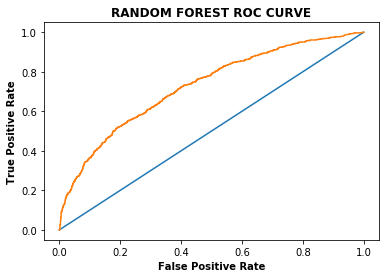

In [45]:
# Plot the ROC Curve and print the AUC

y_score=randomforest.predict_proba(x_test)[:,1]

fpr, tpr,_ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.title("RANDOM FOREST ROC CURVE", fontweight='bold')
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
print("AREA UNDER CURVE: "+str(roc_auc));

[[613 389]
 [282 688]]


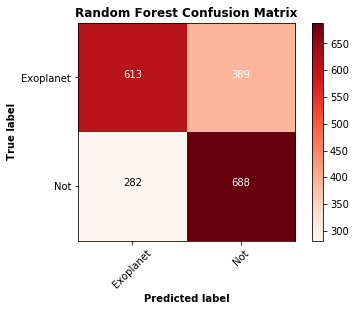

In [52]:
# Print a lovely confusion matrix

plt.tight_layout()
plt.title("Random Forest Confusion Matrix", fontweight='bold')
plt.ylabel('True label', fontweight='bold')
plt.xlabel('Predicted label', fontweight='bold')

plot_confusion_matrix(metrics.confusion_matrix(y_test,y_pred), ['Exoplanet', 'Not'])

# Modeling
### Logistic Regression

In [53]:
# fit a logistic regression model, print the f1 score

logistic = LogisticRegression(penalty='l2', 
                              dual=True, 
                              tol=0.0001, 
                              C=200.0, 
                              fit_intercept=True, 
                              intercept_scaling=1, 
                              class_weight='balanced', 
                              random_state=135, 
                              solver='liblinear', 
                              max_iter=100, 
                              multi_class='ovr', 
                              verbose=0, warm_start=False, n_jobs=1)
logistic.fit(x_train,y_train)
y_pred = logistic.predict(x_test)

In [54]:
# Print a nice little score card for this model
# do you need to normalize?

print("Model accuracy: {:.2f}%".format(logistic.score(x_train, y_train)*100))
print("Model F1 Score: {:.2f}".format(metrics.f1_score(y_pred, y_test)))
print(metrics.classification_report(y_test, logistic.predict(x_test)))

Model accuracy: 50.82%
Model F1 Score: 0.00
             precision    recall  f1-score   support

      False       0.51      1.00      0.67      1002
       True       0.00      0.00      0.00       970

avg / total       0.26      0.51      0.34      1972



/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


AREA UNDER CURVE: 0.5678925653846945


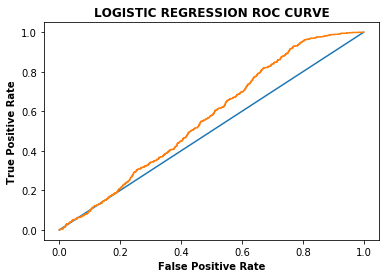

In [55]:
# Plot ROC Curve and print AUC

y_score=logistic.predict_proba(x_test)[:,1]

fpr, tpr,_ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.title("LOGISTIC REGRESSION ROC CURVE", fontweight="bold")
plt.xlabel('False Positive Rate', fontweight="bold")
plt.ylabel('True Positive Rate', fontweight='bold')
print("AREA UNDER CURVE: "+str(roc_auc));

[[1002    0]
 [ 970    0]]


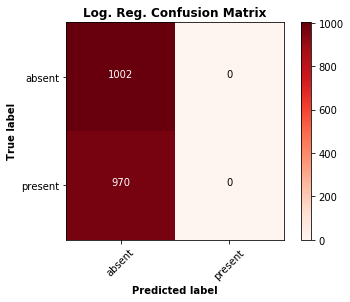

In [56]:
# Print a lovely confusion matrix

plt.tight_layout()
plt.title("Log. Reg. Confusion Matrix", fontweight='bold')
plt.ylabel('True label', fontweight="bold")
plt.xlabel('Predicted label', fontweight='bold')

plot_confusion_matrix(metrics.confusion_matrix(y_test,y_pred), ['absent', 'present'])

# Modeling
### Decision Tree

In [57]:
# Fit a Decision Tree model to the data, with max_depth=60

decisiontree = DecisionTreeClassifier(class_weight = 'balanced', max_depth=5)
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_test)

In [58]:
# Print a nice little score card for this model

print("Model accuracy: {:.2f}%".format(decisiontree.score(x_train, y_train)*100))
print("Model F1 Score: {:.2f}".format(metrics.f1_score(y_pred, y_test)))
print(metrics.classification_report(y_test, decisiontree.predict(x_test)))

Model accuracy: 64.11%
Model F1 Score: 0.70
             precision    recall  f1-score   support

      False       0.78      0.35      0.49      1002
       True       0.57      0.89      0.70       970

avg / total       0.68      0.62      0.59      1972



AREA UNDER CURVE: 0.6418276848365125


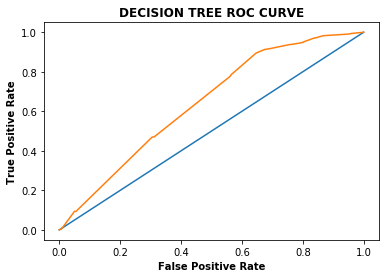

In [59]:
# Plot the ROC Curve and print AUC

y_score=decisiontree.predict_proba(x_test)[:,1]

fpr, tpr,_ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.title("DECISION TREE ROC CURVE", fontweight='bold')
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
print("AREA UNDER CURVE: "+str(roc_auc));

[[354 648]
 [102 868]]


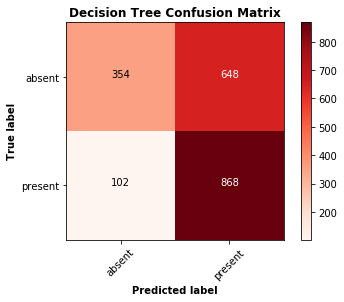

In [60]:
# Print a lovely confusion matrix

plt.tight_layout()
plt.title("Decision Tree Confusion Matrix", fontweight='bold')
plt.ylabel('True label', fontweight='bold')
plt.xlabel('Predicted label', fontweight='bold')

plot_confusion_matrix(metrics.confusion_matrix(y_test,y_pred), ['absent', 'present'])